In [1]:
!pip install yfinance numpy pandas matplotlib nltk feedparser

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import yfinance as yf
import feedparser
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# download VADER lexicon (safe to run repeatedly)
nltk.download("vader_lexicon")

# plotting defaults
plt.rcParams["figure.figsize"] = (10,6)
np.set_printoptions(precision=4, suppress=True)
pd.options.display.float_format = "{:,.4f}".format

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\newse\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [3]:
tickers = ["AAPL", "MSFT", "GOOGL", "AMZN"]

today = datetime.today().date()
start = today - timedelta(days=365*3)  # last 3 years
risk_free_rate = 0.02                  # 2% / year
n_portfolios = 20000                   # number of random portfolios
np.random.seed(42)                     # reproducible

In [4]:
raw = yf.download(tickers, start=start, end=today, auto_adjust=True, progress=False)

# yfinance returns columns like ['Open','High','Low','Close','Volume']
# We want just the close prices for each ticker.
if isinstance(raw.columns, pd.MultiIndex):
    prices = raw["Close"].copy()
else:
    # Single-index (rare) — build a frame
    prices = raw[["Close"]].copy()
    prices.columns = tickers  # best effort

# Ensure columns are the tickers in correct order
prices = prices.dropna(how="all")
prices = prices[tickers]
display(prices.tail())

Ticker,AAPL,MSFT,GOOGL,AMZN
Date,,,,
2025-08-11,227.1800,521.7700,201.0000,221.3000
2025-08-12,229.6500,529.2400,203.3400,221.4700
2025-08-13,233.3300,520.5800,201.9600,224.5600
2025-08-14,232.7800,522.4800,202.9400,230.9800
2025-08-15,231.5900,520.1700,203.9000,231.0300


In [5]:
returns = prices.pct_change().dropna()

# annualized stats (252 trading days)
mu = returns.mean() * 252
cov = returns.cov() * 252

display(mu.to_frame("Annualized Return").T)
display(cov)

Ticker,AAPL,MSFT,GOOGL,AMZN
Annualized Return,0.1395,0.2357,0.2308,0.2217


Ticker,AAPL,MSFT,GOOGL,AMZN
Ticker,,,,
AAPL,0.0794,0.0432,0.0478,0.0514
MSFT,0.0432,0.0671,0.0509,0.0596
GOOGL,0.0478,0.0509,0.0991,0.0686
AMZN,0.0514,0.0596,0.0686,0.1176


In [6]:
results = np.zeros((3, n_portfolios))  # [return, vol, sharpe]
weights_store = []

for i in range(n_portfolios):
    w = np.random.random(len(tickers))
    w /= w.sum()
    weights_store.append(w)

    port_ret = float(np.dot(mu.values, w))
    port_vol = float(np.sqrt(np.dot(w.T, np.dot(cov.values, w))))
    sharpe   = (port_ret - risk_free_rate) / (port_vol + 1e-12)

    results[0, i] = port_ret
    results[1, i] = port_vol
    results[2, i] = sharpe

results_df = pd.DataFrame(results.T, columns=["Return","Volatility","Sharpe"])

imax = results_df["Sharpe"].idxmax()
w_best = weights_store[imax]
base_best = pd.Series(w_best, index=tickers)
base_best /= base_best.sum()

print("Max-Sharpe Portfolio (no sentiment):")
display((base_best*100).round(2).rename("Weight %"))
print("Performance (no sentiment):")
R = results_df.loc[imax, "Return"]; V = results_df.loc[imax, "Volatility"]; S = results_df.loc[imax, "Sharpe"]
print(f"Expected Return: {R:.2%} | Volatility: {V:.2%} | Sharpe: {S:.2f}")

Max-Sharpe Portfolio (no sentiment):


AAPL     0.0200
MSFT    72.7000
GOOGL   25.7500
AMZN     1.5300
Name: Weight %, dtype: float64

Performance (no sentiment):
Expected Return: 23.42% | Volatility: 25.10% | Sharpe: 0.85


In [7]:
def ticker_sentiment(ticker: str, max_items: int = 20) -> float:
    """
    Pull headlines from Google News RSS and average VADER compound scores.
    Fallback to 0 if feed empty or network blocked.
    """
    url = f"https://news.google.com/rss/search?q={ticker}%20stock&hl=en-GB&gl=GB&ceid=GB:en"
    try:
        feed = feedparser.parse(url)
        titles = [e.title for e in feed.entries[:max_items]]
        if not titles:
            return 0.0
        sia = SentimentIntensityAnalyzer()
        scores = [sia.polarity_scores(t)["compound"] for t in titles]
        return float(np.mean(scores))
    except Exception:
        return 0.0

sent_scores = {t: ticker_sentiment(t) for t in tickers}
print("Average news sentiment (−1..+1):", {k: round(v, 3) for k,v in sent_scores.items()})

Average news sentiment (−1..+1): {'AAPL': 0.077, 'MSFT': 0.152, 'GOOGL': 0.122, 'AMZN': 0.239}


In [8]:
adjust_scale = 0.10  # 10% tilt by sentiment
w_adj = base_best.copy()

for t in tickers:
    w_adj[t] = w_adj[t] * (1 + adjust_scale * sent_scores.get(t, 0.0))

w_adj = w_adj / w_adj.sum()

# compute adjusted performance
R_adj = float(np.dot(mu.values, w_adj.values))
V_adj = float(np.sqrt(np.dot(w_adj.values.T, np.dot(cov.values, w_adj.values))))
S_adj = (R_adj - risk_free_rate) / (V_adj + 1e-12)

print("Sentiment-Adjusted Portfolio:")
display((w_adj*100).round(2).rename("Weight %"))
print(f"Adjusted Performance: Return {R_adj:.2%} | Vol {V_adj:.2%} | Sharpe {S_adj:.2f}")

Sentiment-Adjusted Portfolio:


AAPL     0.0200
MSFT    72.7400
GOOGL   25.6900
AMZN     1.5500
Name: Weight %, dtype: float64

Adjusted Performance: Return 23.42% | Vol 25.10% | Sharpe 0.85


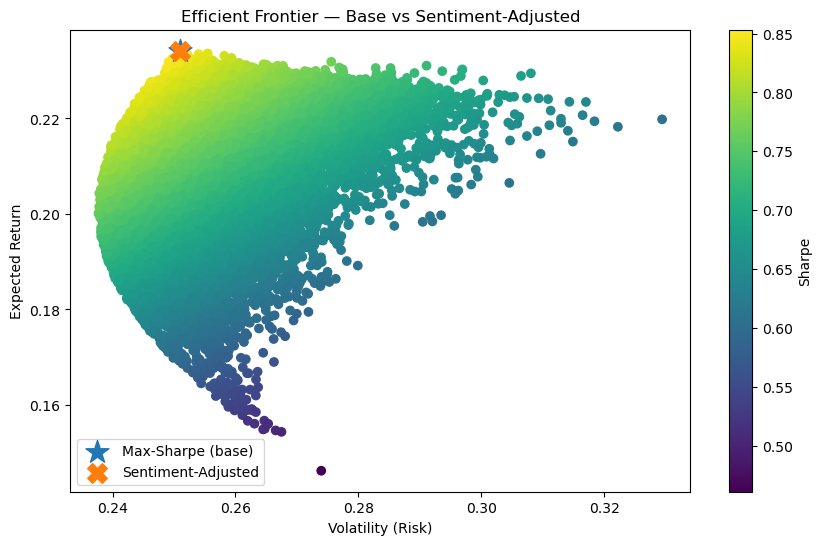

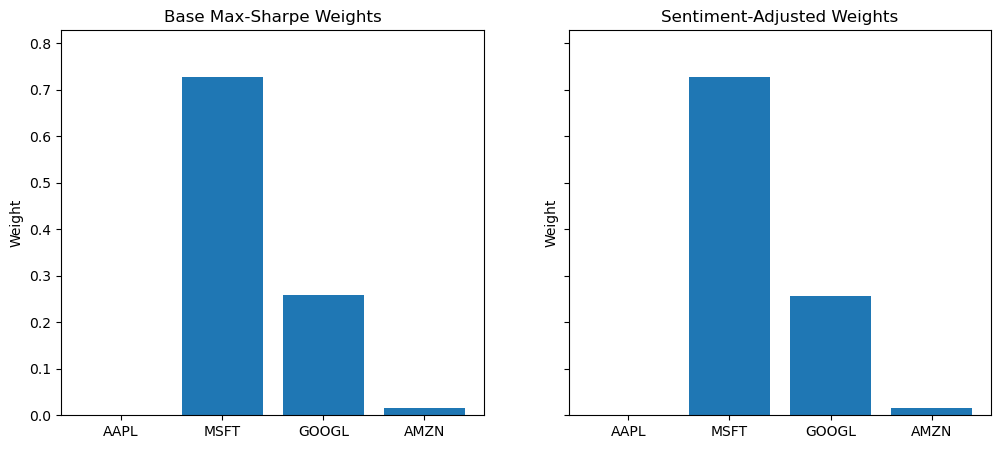

In [9]:
# Efficient frontier cloud + markers
plt.figure(figsize=(10,6))
plt.scatter(results_df["Volatility"], results_df["Return"], c=results_df["Sharpe"], cmap="viridis")
plt.colorbar(label="Sharpe")
plt.scatter(V, R, marker="*", s=300, label="Max-Sharpe (base)")
plt.scatter(V_adj, R_adj, marker="X", s=200, label="Sentiment-Adjusted")
plt.xlabel("Volatility (Risk)")
plt.ylabel("Expected Return")
plt.title("Efficient Frontier — Base vs Sentiment-Adjusted")
plt.legend()
plt.show()

# Allocation bars
fig, ax = plt.subplots(1,2, figsize=(12,5), sharey=True)
ax[0].bar(base_best.index, base_best.values); ax[0].set_title("Base Max-Sharpe Weights")
ax[1].bar(w_adj.index, w_adj.values);       ax[1].set_title("Sentiment-Adjusted Weights")
for a in ax: a.set_ylabel("Weight"); a.set_ylim(0, max(0.6, (w_adj.max()+0.1)))
plt.show()